<a href="https://colab.research.google.com/github/lukehartfield/Instagram-Engagement-Classification/blob/main/AnalyzingInstagramPosts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Analytics for Unstructured Data - Assignment 3
##Group Members -
1. Mihir Jeshurun Gandham
2. Abhilash Bagde
3. Arturo Juarez Jr
4. Vedant Mehrotra
5. Luke Hartfield
6. Bakr Katkhuda

# Task A

We decided to scrape instagram posts from the On brand page

In [ ]:
# pip install apify-client

In [ ]:
from apify_client import ApifyClient
import pandas as pd

def insta_scraper(num_posts, insta_username):

    #Removed API Key
    client = ApifyClient("")

    instagram_handle = [insta_username]
    run_input = {
        "username": instagram_handle,
        "resultsLimit": num_posts,
    }

    run = client.actor("apify/instagram-post-scraper").call(run_input=run_input)

    all_posts = []

    for item in client.dataset(run["defaultDatasetId"]).iterate_items():
        all_posts.append(item)

    post_df = pd.json_normalize(all_posts)

    return post_df


In [ ]:
posts_df = insta_scraper(1000, "on")

In [ ]:
posts_df.to_csv("all_posts.csv")

In [ ]:
clean_posts_df = posts_df.dropna(subset=['likesCount', 'displayUrl'])

In [ ]:
clean_posts_df = clean_posts_df[clean_posts_df['likesCount'] > -1]

In [ ]:
clean_posts_df = clean_posts_df[clean_posts_df['type'] != 'Video']

In [ ]:
len(clean_posts_df)

516

In [ ]:
df = clean_posts_df[['caption', 'likesCount', 'commentsCount', 'displayUrl']]

In [ ]:
df.to_csv("500_insta_posts.csv")

# Task B

In [ ]:
#pip install google-cloud-vision

In [ ]:
#pip install google-auth

In [ ]:
from google.cloud import vision
import io

# Authenticate (replace with your downloaded key path)
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "ascendant-volt-474123-q0-02dcdf3ba611.json"

# Initialize Vision API client
client = vision.ImageAnnotatorClient()


In [ ]:
import requests

def get_image_labels_from_bytes(url, max_labels=8):
    try:
        # download the image content
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        content = response.content

        # wrap content for Vision
        image = vision.Image(content=content)
        vision_response = client.label_detection(image=image)

        if vision_response.error.message:
            print("Vision API error:", vision_response.error.message)
            return []

        labels = [label.description for label in vision_response.label_annotations[:max_labels]]
        return labels

    except Exception as e:
        print("Error processing", url, ":", e)
        return []

df.loc[:, "image_labels"] = df["displayUrl"].apply(get_image_labels_from_bytes)


Error processing https://instagram.ftpa1-2.fna.fbcdn.net/v/t51.29350-15/469832863_2410365102660828_958466111643122947_n.jpg?stp=dst-jpg_e35_tt6&_nc_ht=instagram.ftpa1-2.fna.fbcdn.net&_nc_cat=100&_nc_oc=Q6cZ2QHCRjZc8y9Vy59AjTSA3n2BNoG_v9OYULK2lyYJkllSRggfPN5y0nXVLsSVa4_zmeTF1Uz7gWrjkvKN0sfwQk7n&_nc_ohc=kdRkUwaOM4QQ7kNvwESz30v&_nc_gid=2SRp9lNX-9IbI8SYM2Wzhg&edm=APs17CUBAAAA&ccb=7-5&oh=00_Afd2J8scGXuYjJsn5DECoGiwE9rPm0RCe4Ybs3pzrOCTPg&oe=68E620E0&_nc_sid=10d13b : HTTPSConnectionPool(host='instagram.ftpa1-2.fna.fbcdn.net', port=443): Max retries exceeded with url: /v/t51.29350-15/469832863_2410365102660828_958466111643122947_n.jpg?stp=dst-jpg_e35_tt6&_nc_ht=instagram.ftpa1-2.fna.fbcdn.net&_nc_cat=100&_nc_oc=Q6cZ2QHCRjZc8y9Vy59AjTSA3n2BNoG_v9OYULK2lyYJkllSRggfPN5y0nXVLsSVa4_zmeTF1Uz7gWrjkvKN0sfwQk7n&_nc_ohc=kdRkUwaOM4QQ7kNvwESz30v&_nc_gid=2SRp9lNX-9IbI8SYM2Wzhg&edm=APs17CUBAAAA&ccb=7-5&oh=00_Afd2J8scGXuYjJsn5DECoGiwE9rPm0RCe4Ybs3pzrOCTPg&oe=68E620E0&_nc_sid=10d13b (Caused by NameResolutionE

In [ ]:
df.head(5)

,caption,likesCount,commentsCount,displayUrl,image_labels
0,Meet On GuardTec™. 👋 🌧️\n\nSwiss-engineered On...,3045,17,https://scontent-iad3-1.cdninstagram.com/v/t51...,[Hood]
1,Seriously waterproof. Seriously tested. On Gua...,6544,48,https://scontent-lax3-1.cdninstagram.com/v/t51...,"[Sleeve, Windbreaker, Hood, Hoodie]"
2,Five championship races. Six podiums. One Trai...,2392,18,https://scontent-dfw5-1.cdninstagram.com/v/t51...,"[Adventure, Recreation, Outdoor recreation, Ro..."
3,For stories worth exploring. 🌲\n\nFrom the for...,4973,64,https://scontent-mia3-3.cdninstagram.com/v/t51...,"[Recreation, Leisure, People in nature, Fun, C..."
4,On DryTec™. Seriously quick-drying. 💨\n\nSwiss...,1457,11,https://scontent-ord5-1.cdninstagram.com/v/t51...,"[Standing, Sportswear, Luggage & bags, Bag, Ba..."


In [ ]:
df.to_csv("500_insta_posts_with_labels.csv", index=False)

# Task C

In [ ]:
import pandas as pd

In [ ]:
posts = pd.read_csv('500_insta_posts_with_labels.xls')
posts = posts[(posts['image_labels'] != '[]') & (posts['image_labels'].notna())]
posts

,caption,likesCount,commentsCount,displayUrl,image_labels
0,Meet On GuardTec™. 👋 🌧️\n\nSwiss-engineered On...,3045,17,https://scontent-iad3-1.cdninstagram.com/v/t51...,['Hood']
1,Seriously waterproof. Seriously tested. On Gua...,6544,48,https://scontent-lax3-1.cdninstagram.com/v/t51...,"['Sleeve', 'Windbreaker', 'Hood', 'Hoodie']"
2,Five championship races. Six podiums. One Trai...,2392,18,https://scontent-dfw5-1.cdninstagram.com/v/t51...,"['Adventure', 'Recreation', 'Outdoor recreatio..."
3,For stories worth exploring. 🌲\n\nFrom the for...,4973,64,https://scontent-mia3-3.cdninstagram.com/v/t51...,"['Recreation', 'Leisure', 'People in nature', ..."
4,On DryTec™. Seriously quick-drying. 💨\n\nSwiss...,1457,11,https://scontent-ord5-1.cdninstagram.com/v/t51...,"['Standing', 'Sportswear', 'Luggage & bags', '..."
...,...,...,...,...,...
511,A high performance running shoe made from bean...,9361,196,https://scontent-atl3-3.cdninstagram.com/v/t51...,"['Sportswear', 'Sneakers', 'Walking Shoe', 'Ou..."
512,We live in a world of constant content. Yet we...,3325,37,https://scontent-atl3-1.cdninstagram.com/v/t51...,"['Publication', 'Advertising', 'Book', 'Book c..."
513,“We’re all runners. And no matter what level o...,2645,34,https://scontent-bos5-1.cdninstagram.com/v/t51...,"['Shoe', 'Leg', 'Calf', 'Sportswear', 'Thigh',..."
514,Looking for a gift for the trail runner in you...,2686,29,https://scontent-lga3-1.cdninstagram.com/v/t51...,"['Recreation', 'Adventure', 'Wilderness', 'Tra..."


In [ ]:
posts['binary'] = (posts['likesCount'] > posts['likesCount'].median()).astype(int)
posts

,caption,likesCount,commentsCount,displayUrl,image_labels,binary
0,Meet On GuardTec™. 👋 🌧️\n\nSwiss-engineered On...,3045,17,https://scontent-iad3-1.cdninstagram.com/v/t51...,['Hood'],0
1,Seriously waterproof. Seriously tested. On Gua...,6544,48,https://scontent-lax3-1.cdninstagram.com/v/t51...,"['Sleeve', 'Windbreaker', 'Hood', 'Hoodie']",1
2,Five championship races. Six podiums. One Trai...,2392,18,https://scontent-dfw5-1.cdninstagram.com/v/t51...,"['Adventure', 'Recreation', 'Outdoor recreatio...",0
3,For stories worth exploring. 🌲\n\nFrom the for...,4973,64,https://scontent-mia3-3.cdninstagram.com/v/t51...,"['Recreation', 'Leisure', 'People in nature', ...",0
4,On DryTec™. Seriously quick-drying. 💨\n\nSwiss...,1457,11,https://scontent-ord5-1.cdninstagram.com/v/t51...,"['Standing', 'Sportswear', 'Luggage & bags', '...",0
...,...,...,...,...,...,...
511,A high performance running shoe made from bean...,9361,196,https://scontent-atl3-3.cdninstagram.com/v/t51...,"['Sportswear', 'Sneakers', 'Walking Shoe', 'Ou...",1
512,We live in a world of constant content. Yet we...,3325,37,https://scontent-atl3-1.cdninstagram.com/v/t51...,"['Publication', 'Advertising', 'Book', 'Book c...",0
513,“We’re all runners. And no matter what level o...,2645,34,https://scontent-bos5-1.cdninstagram.com/v/t51...,"['Shoe', 'Leg', 'Calf', 'Sportswear', 'Thigh',...",0
514,Looking for a gift for the trail runner in you...,2686,29,https://scontent-lga3-1.cdninstagram.com/v/t51...,"['Recreation', 'Adventure', 'Wilderness', 'Tra...",0


# Task D

MODEL 1: IMAGE LABELS ONLY
Accuracy (Image Labels): 0.5882

Confusion Matrix:
[[34 17]
 [25 26]]


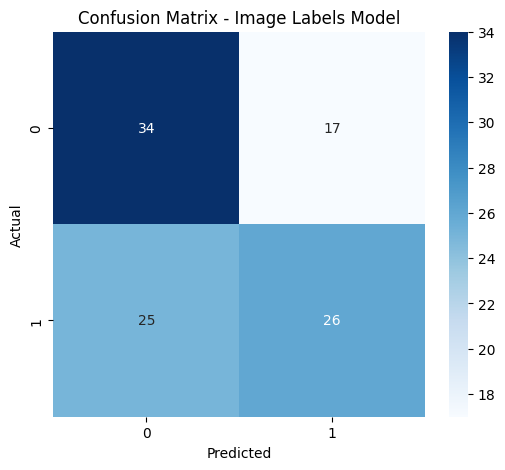


Top 10 Most Positive Image Labels for High Engagement:
         feature  coefficient
16  championship     1.626693
97   windbreaker     1.493554
66       racquet     1.483930
32          foot     1.113958
84        tennis     0.862355
27    expression     0.704597
71         shoot     0.655322
9        balance     0.643453
67    recreation     0.641765
91    undershirt     0.597725

MODEL 2: CAPTIONS ONLY
Accuracy (Captions): 0.7059

Confusion Matrix:
[[33 18]
 [12 39]]


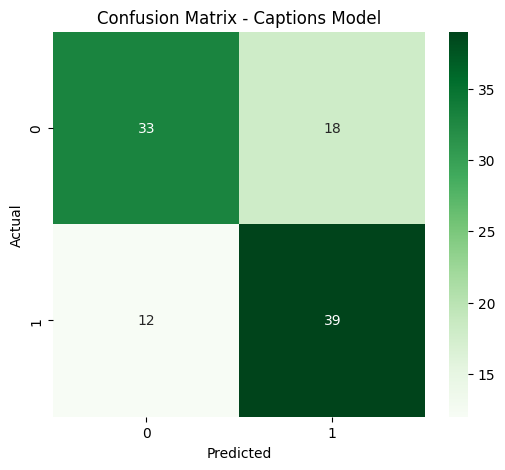


Top 10 Most Positive Caption Words for High Engagement:
       feature  coefficient
428        tap     1.214748
52    breaking     0.976395
259      loewe     0.936464
497    zendaya     0.928662
69     chapter     0.887434
51      boston     0.870527
80   cloudtilt     0.870479
459  unmatched     0.807196
162  featuring     0.735270
3          100     0.728458

MODEL 3: COMBINED (IMAGE LABELS + CAPTIONS)
Accuracy (Combined): 0.7157

Confusion Matrix:
[[34 17]
 [12 39]]


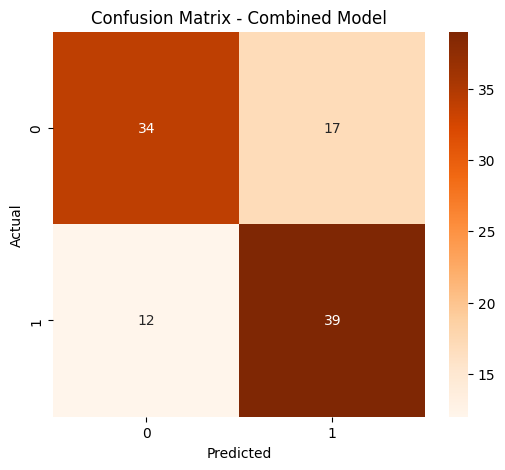


Top 10 Most Positive Combined Features for High Engagement:
          feature  coefficient
514           tap     1.217230
397        player     1.080921
416       racquet     1.060148
597       zendaya     1.004045
80   championship     0.987411
131         dance     0.864762
311         loewe     0.860897
222          gear     0.800517
62         boston     0.797087
546         ultra     0.790559

MODEL COMPARISON
          Model  Accuracy  Features Used
2      Combined  0.715686            600
1      Captions  0.705882            500
0  Image Labels  0.588235            100


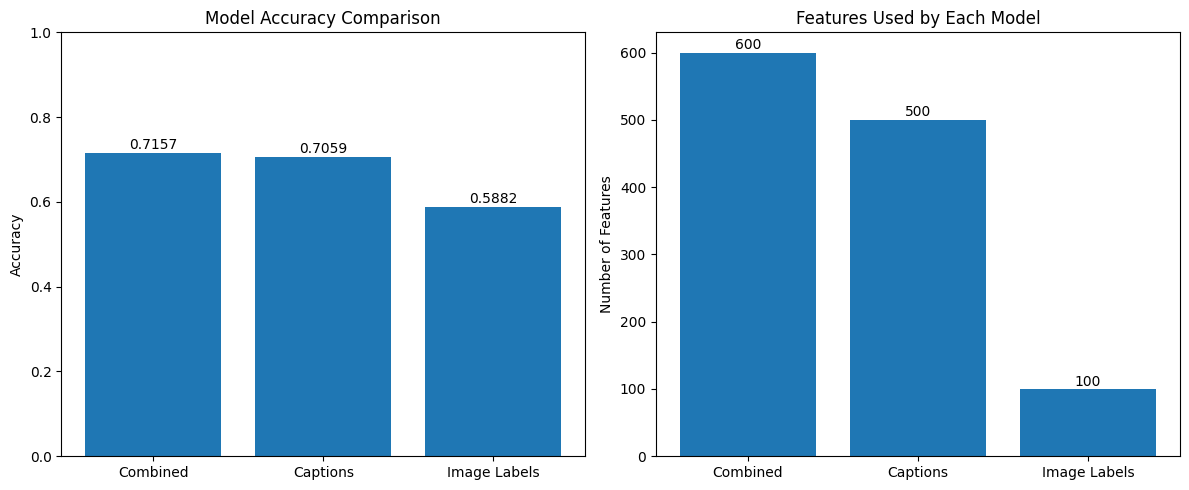


ANALYSIS AND CONCLUSIONS

Key Findings:
-------------
1. IMAGE LABELS MODEL:
   - Accuracy: 0.5882
   - Uses 100 visual features
   - Performance: Above baseline

2. CAPTIONS MODEL:
   - Accuracy: 0.7059
   - Uses 500 text features
   - Performance: Better than image labels

3. COMBINED MODEL:
   - Accuracy: 0.7157
   - Uses 600 total features
   - Performance: Best overall

Conclusions:
------------

1. The Combined model achieves the highest accuracy at 0.7157
2. Combined model improves 21.67% over image labels alone
3. Combined model improves 1.39% over captions alone


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================
# Prepare Image Labels Data
# ============================================

def clean_image_labels(labels_str):
    """Clean and extract image labels from string representation"""
    if pd.isna(labels_str):
        return ''

    # Remove brackets and quotes
    labels_str = str(labels_str)
    labels_str = labels_str.strip("[]")
    labels_str = labels_str.replace("'", "")
    labels_str = labels_str.replace('"', '')

    # Split by comma and clean each label
    labels = [label.strip() for label in labels_str.split(',')]

    # Join labels with space for BoW
    return ' '.join(labels)

# Clean image labels
posts['image_labels_clean'] = posts['image_labels'].apply(clean_image_labels)

# ============================================
# Prepare Caption Data
# ============================================

def clean_caption(text):
    """Clean caption text for analysis"""
    if pd.isna(text):
        return ''

    text = str(text)

    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # Remove hashtags (but keep the word)
    text = re.sub(r'#(\w+)', r'\1', text)

    # Remove special characters and emojis
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove extra whitespace
    text = ' '.join(text.split())

    return text

# Clean captions
posts['caption_clean'] = posts['caption'].apply(clean_caption)

# ============================================
# Model 1 - Using Image Labels Only
# ============================================

print("=" * 60)
print("MODEL 1: IMAGE LABELS ONLY")
print("=" * 60)

# Prepare features and target
X_labels = posts['image_labels_clean']
y = posts['binary']

# Split data
X_train_labels, X_test_labels, y_train, y_test = train_test_split(
    X_labels, y, test_size=0.2, random_state=42, stratify=y
)

# Create BoW features for image labels
vectorizer_labels = CountVectorizer(
    max_features=100,  # Limit features since image labels are limited
    binary=True  # Use binary features (presence/absence)
)

X_train_labels_bow = vectorizer_labels.fit_transform(X_train_labels)
X_test_labels_bow = vectorizer_labels.transform(X_test_labels)

# Train logistic regression
model_labels = LogisticRegression(random_state=42, max_iter=1000)
model_labels.fit(X_train_labels_bow, y_train)

# Predictions
y_pred_labels = model_labels.predict(X_test_labels_bow)

# Calculate accuracy
accuracy_labels = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy (Image Labels): {accuracy_labels:.4f}")

# Confusion matrix
cm_labels = confusion_matrix(y_test, y_pred_labels)
print("\nConfusion Matrix:")
print(cm_labels)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_labels, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Image Labels Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Top features
feature_importance_labels = pd.DataFrame({
    'feature': vectorizer_labels.get_feature_names_out(),
    'coefficient': model_labels.coef_[0]
}).sort_values('coefficient', ascending=False)

print("\nTop 10 Most Positive Image Labels for High Engagement:")
print(feature_importance_labels.head(10))

# ============================================
# Model 2 - Using Captions Only
# ============================================

print("\n" + "=" * 60)
print("MODEL 2: CAPTIONS ONLY")
print("=" * 60)

# Prepare features
X_captions = posts['caption_clean']

# Split data
X_train_captions, X_test_captions, y_train, y_test = train_test_split(
    X_captions, y, test_size=0.2, random_state=42, stratify=y
)

# Create BoW features for captions
vectorizer_captions = CountVectorizer(
    max_features=500,  # More features for text
    min_df=2,  # Ignore terms that appear in less than 2 documents
    stop_words='english'  # Remove common English stop words
)

X_train_captions_bow = vectorizer_captions.fit_transform(X_train_captions)
X_test_captions_bow = vectorizer_captions.transform(X_test_captions)

# Train logistic regression
model_captions = LogisticRegression(random_state=42, max_iter=1000)
model_captions.fit(X_train_captions_bow, y_train)

# Predictions
y_pred_captions = model_captions.predict(X_test_captions_bow)

# Calculate accuracy
accuracy_captions = accuracy_score(y_test, y_pred_captions)
print(f"Accuracy (Captions): {accuracy_captions:.4f}")

# Confusion matrix
cm_captions = confusion_matrix(y_test, y_pred_captions)
print("\nConfusion Matrix:")
print(cm_captions)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_captions, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Captions Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Top features
feature_importance_captions = pd.DataFrame({
    'feature': vectorizer_captions.get_feature_names_out(),
    'coefficient': model_captions.coef_[0]
}).sort_values('coefficient', ascending=False)

print("\nTop 10 Most Positive Caption Words for High Engagement:")
print(feature_importance_captions.head(10))

# ============================================
# Model 3 - Combined Features
# ============================================

print("\n" + "=" * 60)
print("MODEL 3: COMBINED (IMAGE LABELS + CAPTIONS)")
print("=" * 60)

# Combine image labels and captions
posts['combined_text'] = posts['image_labels_clean'] + ' ' + posts['caption_clean']

# Prepare features
X_combined = posts['combined_text']

# Split data
X_train_combined, X_test_combined, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42, stratify=y
)

# Create BoW features for combined text
vectorizer_combined = CountVectorizer(
    max_features=600,  # More features for combined text
    min_df=2,
    stop_words='english'
)

X_train_combined_bow = vectorizer_combined.fit_transform(X_train_combined)
X_test_combined_bow = vectorizer_combined.transform(X_test_combined)

# Train logistic regression
model_combined = LogisticRegression(random_state=42, max_iter=1000)
model_combined.fit(X_train_combined_bow, y_train)

# Predictions
y_pred_combined = model_combined.predict(X_test_combined_bow)

# Calculate accuracy
accuracy_combined = accuracy_score(y_test, y_pred_combined)
print(f"Accuracy (Combined): {accuracy_combined:.4f}")

# Confusion matrix
cm_combined = confusion_matrix(y_test, y_pred_combined)
print("\nConfusion Matrix:")
print(cm_combined)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_combined, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - Combined Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Top features
feature_importance_combined = pd.DataFrame({
    'feature': vectorizer_combined.get_feature_names_out(),
    'coefficient': model_combined.coef_[0]
}).sort_values('coefficient', ascending=False)

print("\nTop 10 Most Positive Combined Features for High Engagement:")
print(feature_importance_combined.head(10))

# ============================================
# Compare All Models
# ============================================

print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Image Labels', 'Captions', 'Combined'],
    'Accuracy': [accuracy_labels, accuracy_captions, accuracy_combined],
    'Features Used': [
        X_train_labels_bow.shape[1],
        X_train_captions_bow.shape[1],
        X_train_combined_bow.shape[1]
    ]
})

comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
print(comparison_df)

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy comparison
ax1.bar(comparison_df['Model'], comparison_df['Accuracy'])
ax1.set_ylabel('Accuracy')
ax1.set_title('Model Accuracy Comparison')
ax1.set_ylim([0, 1])
for i, v in enumerate(comparison_df['Accuracy']):
    ax1.text(i, v + 0.01, f'{v:.4f}', ha='center')

# Features comparison
ax2.bar(comparison_df['Model'], comparison_df['Features Used'])
ax2.set_ylabel('Number of Features')
ax2.set_title('Features Used by Each Model')
for i, v in enumerate(comparison_df['Features Used']):
    ax2.text(i, v + 5, str(v), ha='center')

plt.tight_layout()
plt.show()

# ============================================
# Analysis and Conclusions
# ============================================

print("\n" + "=" * 60)
print("ANALYSIS AND CONCLUSIONS")
print("=" * 60)

print(f"""
Key Findings:
-------------
1. IMAGE LABELS MODEL:
   - Accuracy: {accuracy_labels:.4f}
   - Uses {X_train_labels_bow.shape[1]} visual features
   - Performance: {'Above baseline' if accuracy_labels > 0.5 else 'At baseline'}

2. CAPTIONS MODEL:
   - Accuracy: {accuracy_captions:.4f}
   - Uses {X_train_captions_bow.shape[1]} text features
   - Performance: {'Better than image labels' if accuracy_captions > accuracy_labels else 'Worse than image labels'}

3. COMBINED MODEL:
   - Accuracy: {accuracy_combined:.4f}
   - Uses {X_train_combined_bow.shape[1]} total features
   - Performance: {'Best overall' if accuracy_combined >= max(accuracy_labels, accuracy_captions) else 'Not optimal'}

Conclusions:
------------
""")

# Determine which model performs best
best_model = comparison_df.iloc[0]['Model']
best_accuracy = comparison_df.iloc[0]['Accuracy']

print(f"1. The {best_model} model achieves the highest accuracy at {best_accuracy:.4f}")

# Calculate improvements
if accuracy_combined > accuracy_labels:
    improvement_over_labels = ((accuracy_combined - accuracy_labels) / accuracy_labels) * 100
    print(f"2. Combined model improves {improvement_over_labels:.2f}% over image labels alone")

if accuracy_combined > accuracy_captions:
    improvement_over_captions = ((accuracy_combined - accuracy_captions) / accuracy_captions) * 100
    print(f"3. Combined model improves {improvement_over_captions:.2f}% over captions alone")




Key Findings:
Captions outperform image labels significantly.

Captions: 70.59% accuracy\
Image labels: 58.82% accuracy\
Combined: 71.57% accuracy

The combined model performs slightly better than captions alone and much better than image labels alone. This suggests that:

Complementary Signal:
Image labels add marginal but helpful visual cues that captions don’t always fully capture.

Limited Noise Impact:
While some labels (like “windbreaker” or “undershirt”) may not drive engagement, the useful ones (e.g., “championship”, “player”, “racquet”) make up for it.

No Feature Dilution:
Since the combined model outperforms both individual models, dilution is not a problem here.

Small Gain = Diminishing Returns:
Because captions already carry rich information, visual features only improve performance slightly.

# Task E

In [ ]:
# === Term × Topic weights + likes (LDA, K=7) ===
import pandas as pd, numpy as np, re
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

OUT_CSV = Path("lda_term_topic_weights_with_likes_k6.csv")
N_TOPICS, MIN_DF, MAX_DF = 6, 3, 0.8

DOMAIN_STOPWORDS = {
     "shoe","shoes","sneaker","sneakers","footwear","sock","socks",
    "sport","sports","sportswear"
}
# We removed brand-generic domain stopwords (e.g., “shoe,” “sneakers,” “sportswear”) so the topics don’t get dominated by obvious product terms and instead highlight more meaningful themes that differentiate high- vs low-engagement content.

df = posts.copy()

def norm(c): return re.sub(r'[^a-z0-9]+','_', str(c).strip().lower()).strip('_')
df.columns = [norm(c) for c in df.columns]
label_col = "image_labels" if "image_labels" in df.columns else max(df.columns, key=lambda c: df[c].astype(str).str.len().mean())
likes_col = "likescount" if "likescount" in df.columns else max(df.columns, key=lambda c: pd.to_numeric(df[c], errors="coerce").notna().mean())

df["likes_numeric"] = pd.to_numeric(df[likes_col], errors="coerce")
df = df.dropna(subset=[label_col, "likes_numeric"]).reset_index(drop=True)

labels_text = (df[label_col].astype(str)
               .str.replace(r"[,\|;/]+"," ", regex=True)
               .str.replace(r"\s+"," ", regex=True)
               .str.strip())

custom_stop = list(ENGLISH_STOP_WORDS.union(DOMAIN_STOPWORDS))
vectorizer = CountVectorizer(
    lowercase=True,
    stop_words=custom_stop,
    token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z\-]+\b",
    min_df=MIN_DF, max_df=MAX_DF
)
X = vectorizer.fit_transform(labels_text)

lda = LatentDirichletAllocation(n_components=N_TOPICS, learning_method="batch",
                                max_iter=20, random_state=42).fit(X)

vocab = np.array(vectorizer.get_feature_names_out())
topic_word = lda.components_ / lda.components_.sum(axis=1, keepdims=True)

term_topic = pd.DataFrame(topic_word.T, columns=[f"topic_{k}" for k in range(N_TOPICS)])
term_topic.insert(0, "term", vocab)

X_bin = (X > 0).astype(int)
likes = df["likes_numeric"].to_numpy()
avg_likes = []
for j in range(X_bin.shape[1]):
    m = X_bin[:, j].toarray().ravel().astype(bool)
    avg_likes.append(float(np.nanmean(likes[m])) if m.any() else np.nan)

term_topic["likes"] = avg_likes
# term_topic.to_csv(OUT_CSV, index=False)
print(f"Wrote {OUT_CSV} with shape {term_topic.shape}")


Wrote lda_term_topic_weights_with_likes_k6.csv with shape (210, 8)


In [ ]:
import pandas as pd, numpy as np, re
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import LatentDirichletAllocation

N_TOPICS = 6
MIN_DF, MAX_DF = 3, 0.8
DOMAIN_STOPWORDS = { "shoe","shoes","sneaker","sneakers","footwear","sock","socks", "sport","sports","sportswear" }

df = posts.copy()
def norm(c): return re.sub(r'[^a-z0-9]+','_', str(c).strip().lower()).strip('_')
df.columns = [norm(c) for c in df.columns]
label_col = "image_labels" if "image_labels" in df.columns else max(df.columns, key=lambda c: df[c].astype(str).str.len().mean())
likes_col = "likescount" if "likescount" in df.columns else max(df.columns, key=lambda c: pd.to_numeric(df[c], errors="coerce").notna().mean())

df["likes_numeric"] = pd.to_numeric(df[likes_col], errors="coerce")
df = df.dropna(subset=[label_col, "likes_numeric"]).reset_index(drop=True)

labels_text = (df[label_col].astype(str)
               .str.replace(r"[,\|;/]+"," ", regex=True)
               .str.replace(r"\s+"," ", regex=True)
               .str.strip())

custom_stop = list(ENGLISH_STOP_WORDS.union(DOMAIN_STOPWORDS))
vectorizer = CountVectorizer(lowercase=True, stop_words=custom_stop,
                             token_pattern=r"(?u)\b[a-zA-Z][a-zA-Z\-]+\b",
                             min_df=MIN_DF, max_df=MAX_DF)
X = vectorizer.fit_transform(labels_text)

lda = LatentDirichletAllocation(n_components=N_TOPICS, learning_method="batch",
                                max_iter=20, random_state=42).fit(X)

doc_topic = lda.transform(X)
topic_cols = [f"topic_{k}" for k in range(N_TOPICS)]
df_topics = pd.concat([df[["likes_numeric"]].reset_index(drop=True),
                       pd.DataFrame(doc_topic, columns=topic_cols)], axis=1)
# df_topics.to_csv("doc_topic_weights_k6.csv", index=False)

q1 = df_topics["likes_numeric"].quantile(0.25)
q3 = df_topics["likes_numeric"].quantile(0.75)
low_q  = df_topics[df_topics["likes_numeric"] <= q1]
high_q = df_topics[df_topics["likes_numeric"] >= q3]

avg_low  = low_q[topic_cols].mean().rename("avg_low_q")
avg_high = high_q[topic_cols].mean().rename("avg_high_q")
diff = (avg_high - avg_low).rename("high_minus_low")
summary = pd.concat([avg_low, avg_high, diff], axis=1).reset_index().rename(columns={"index":"topic"})
# summary.to_csv("lda_quartile_topic_weight_comparison_k6.csv", index=False)
print("Wrote: doc_topic_weights_k6.csv and lda_quartile_topic_weight_comparison_k6.csv")

Wrote: doc_topic_weights_k6.csv and lda_quartile_topic_weight_comparison_k6.csv


In [ ]:
# Build quartile comparison directly from the fitted LDA (K=6) and your CountVectorizer.
# Assumes you have df (with likes), vectorizer, and lda already fitted on labels_text.

import numpy as np
import pandas as pd

# 1) Get per-post topic weights (doc-topic matrix)
doc_topic = lda.transform(X)  # X == vectorizer.fit_transform(labels_text)
topic_cols = [f"topic_{k}" for k in range(lda.n_components)]
doc_topic_df = pd.DataFrame(doc_topic, columns=topic_cols)

# 2) Attach likes
tmp = pd.DataFrame({"likes_numeric": df["likes_numeric"].values})
tmp = pd.concat([tmp.reset_index(drop=True), doc_topic_df], axis=1)

# 3) Quartiles on ACTUAL likes
q1 = tmp["likes_numeric"].quantile(0.25)
q3 = tmp["likes_numeric"].quantile(0.75)
low_q  = tmp[tmp["likes_numeric"] <= q1]
high_q = tmp[tmp["likes_numeric"] >= q3]

# 4) Averages and differences
avg_low  = low_q[topic_cols].mean().rename("avg_low_q")
avg_high = high_q[topic_cols].mean().rename("avg_high_q")
diff = (avg_high - avg_low).rename("high_minus_low")

summary = (
    pd.concat([avg_low, avg_high, diff], axis=1)
      .reset_index().rename(columns={"index":"topic"})
      .sort_values("high_minus_low", ascending=False)
)

# OPTIONAL: add your topic names (map manually or from your top-terms)
topic_name_map = {
    "topic_0": "Tennis",
    "topic_1": "Hiking",
    "topic_2": "Upper Body Apparel",
    "topic_3": "Fashion Photography",
    "topic_4": "Graphic Design",
    "topic_5": "Athletics"
}
summary["topic_name"] = summary["topic"].map(topic_name_map)

# summary.to_csv("lda_quartile_topic_weight_comparison_k6.csv", index=False)
print(summary)

     topic  avg_low_q  avg_high_q  high_minus_low           topic_name
0  topic_0   0.160996    0.301842        0.140846               Tennis
3  topic_3   0.207586    0.252353        0.044767  Fashion Photography
1  topic_1   0.041713    0.068239        0.026525               Hiking
2  topic_2   0.198669    0.133985       -0.064685   Upper Body Apparel
4  topic_4   0.176234    0.108790       -0.067444       Graphic Design
5  topic_5   0.214802    0.134792       -0.080010            Athletics


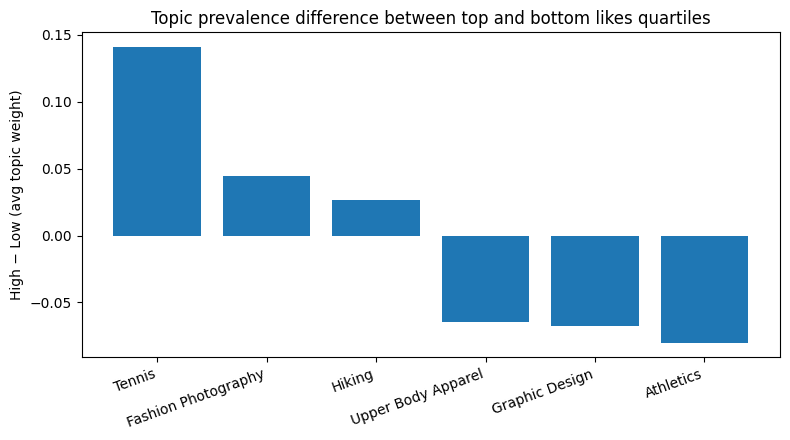

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# summary = pd.read_csv("lda_quartile_topic_weight_comparison_k6.csv")
summary = summary.sort_values("high_minus_low", ascending=False)

plt.figure(figsize=(8,4.5))
plt.bar(summary["topic_name"], summary["high_minus_low"])
plt.xticks(rotation=20, ha="right")
plt.ylabel("High − Low (avg topic weight)")
plt.title("Topic prevalence difference between top and bottom likes quartiles")
plt.tight_layout()
plt.show()

# Task F

## Advice to ON for Increasing Instagram Engagement (Based on Logistic Regression and LDA)

Based on the predictive performance of the models, captions play a stronger role in driving engagement than image content alone, and combining both yields the best results. Here are the key takeaways and practical recommendations:

### 1. Prioritize High-Impact Caption Content

Since the caption-only model achieved 70.6% accuracy — far better than the 58.8% from image labels. It is clear that what the brand writes matters more than just what is shown visually.

**Actionable Advice:**

* Use names, collaborations, or cultural references (e.g., Zendaya, Loewe, Boston, featuring), which ranked high among the most predictive words.
* Include call-to-action or high-energy terms (e.g., tap, breaking, unmatched).
* Incorporate event or performance-related language (e.g., chapter, featuring, player).

### 2. Use Visual Themes That Align With Engagement Drivers

Even though captions outperform visuals, the model with image labels still provides useful signals. For example, high-coefficient visual tags include terms: championship, racquet, player, tennis, and expression.

**Actionable Advice:**

* Feature sports, performance, and action-oriented visuals
* Highlight faces and dynamic expressions
* Use props or scenes that evoke motion, competition, or identity

### 3. Combine Visual + Text Strategy for Best Results

The combined model (71.6% accuracy) slightly outperformed the caption-only model, showing that visuals still add value when paired thoughtfully with text.

**Actionable Advice:**

* Align captions with visual themes (e.g., tennis imagery + captions mentioning athletes or events)
* Use branded or style-specific terms that reinforce visual cues
* Avoid irrelevant or overly generic imagery (e.g., product-only shots without context)

### 4. Reduce Low-Signal Visual Content

Some image labels like undershirt and windbreaker do not appear strongly related to high engagement.

**Actionable Advice:**

* Use fewer generic product-only images without narrative context
* Avoid crowding the feed with visuals that lack emotion, performance, or storytelling


### 5. Insights from LDA

Based on the topic modeling (Task E) comparing high- and low-engagement posts, the following insights were drawn:

#### What we learned
- **Top performers**: Tennis and Lifestyle fashion/model.
Posts that show tennis in action (+0.10 High−Low) and lifestyle/model shots (+0.09) appear much more often among the most-liked posts. In plain terms: audiences respond when they see real sport moments or a styled look being worn in a relatable scene. These formats make the product feel part of a story (competition, identity, aspiration), which encourages more interaction.
- **Small lift**: Hiking/outdoor.
Outdoor content (~+0.02) gives a modest uptick. It likely benefits from motion and scenery, but not as strongly as tennis or fashion. It’s a good supporting theme to keep variety in the feed.
- **Underperformers**: Upper-body apparel, Graphic/design, Generic “athletics.”
These skew to lower likes. Common thread: they feel less like a moment and more like a product card. When there’s no sport or lifestyle context (e.g., studio crops, poster-style graphics, or generic training shots with no clear story), audiences engage less.

#### What to post more
- **Tennis action (35–45% of weekly posts):**
Make this the anchor. Feature real match/practice moments that clearly signal tennis (racket, court, point in play). This content consistently correlates with higher engagement for your audience.
- **Lifestyle fashion/model (25–30%):**
Use model-in-context visuals—street or event settings where the outfit is worn and styled. This format taps into identity and aspiration, which the data shows your followers reward with more likes.
- **Hiking/outdoor lifestyle (10–15%):**
Keep a steady presence for variety—trail scenes, motion, and group moments. It adds breadth without diluting the high performers.

#### What to post less (or reframe)
- **Upper-body apparel close-ups:**
Use sparingly, and only when tied to a real moment (e.g., athlete interview, pre-match tunnel, post-run recap). The data suggests product-only frames underperform on their own.
- **Graphic/design posts:**
Reserve for big news (launches, collabs, events) and ideally place them after a strong image in a carousel. Let the story image attract engagement; use the graphic to deliver details.
- **Generic “athletics”:**
Make it specific—what sport, what moment, what’s at stake. “Tennis practice,” “race day,” or “interval session” will perform better than a vague training shot.



